# A Quick Intro to Plotting Glider Data in Python
**Oceanography House Fall 2020**

*Written by Sage Lichtenwalner, Rutgers University, October 2, 2020*

In this notebook, we will demonstrate how to access and plot Glider data available form the [IOOS Glider Data Assembly Center](https://gliders.ioos.us) (DAC).  

To browse the datasets available in the DAC, check out the [Glider DAC Map](https://gliders.ioos.us/map/).

In [1]:
# Setup notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To setup prettier graphs, uncomment the following lines
# import seaborn as sns 
# sns.set()

## Loading Glider Data
For this example, we'll pull some recent data from [Glider RU33](https://marine.rutgers.edu/cool/data/gliders/deployments/deployment.php?deployment=ru33-20200826T1604&iserver=maps).  

To generate the dataset URL I need, I used the Erddap Data Access form for deployment [ru33-20200826T1604](https://gliders.ioos.us/erddap/tabledap/ru33-20200826T1604.html).  (I found this link using the Glider DAC Map).

Using the form, I specified:
* the **timerange** I'm interested in (we'll start with 7 days to speed things up)
* the **variables** I wanted - basically just the coordinates (time, lat, lon, depth) and key variables (temperature, salinity, density)
* and the file type as **.csv**.  You could also use .csvp if you don't mind the units being in your variable names.

When you're done, you can click the "Just generate the url" button and paste the result into your code as a variable.

In [2]:
url = 'https://gliders.ioos.us/erddap/tabledap/ru33-20200826T1604.csv?profile_id%2Ctime%2Clatitude%2Clongitude%2Cdepth%2Ctemperature%2Csalinity%2Cdensity&time%3E=2020-09-18T00%3A00%3A00Z&time%3C=2020-09-25T00%3A00%3A00Z'

As we demonstrated in the [first notebook](https://github.com/ooi-data-lab/data-lab-workshops/blob/master/Other_Examples/OH2020_Python_Basics.ipynb), we can now use **Pandas** to load this CSV dataset.

However, in this case, our CSV file includes units in the 2nd row, so we need to tell the `read_csv()` function to skip that row (which is line 1 in python-speak).

In addition, by default, Pandas won't convert datetime strings into objects it knows how to deal with.  Thankfully, we can use the `parse_dates` parameter to tell it to convert the "time" column.

We also want to make "time" the index column.

In [3]:
# Load the dataset
data = pd.read_csv(url, skiprows=[1], parse_dates=['time'], index_col='time')

In [4]:
# Quick look at the dataset
data.head()

,profile_id,latitude,longitude,depth,temperature,salinity,density
time,,,,,,,
2020-09-18 00:00:44+00:00,1600102362,38.975039,-73.476108,1.510873,22.9990,31.716364,1021.4586
2020-09-18 00:00:44+00:00,1600102362,38.975039,-73.476108,1.697349,22.9969,31.717842,1021.4597
2020-09-18 00:00:44+00:00,1600102362,38.975039,-73.476108,NaN,NaN,NaN,NaN
2020-09-18 00:00:44+00:00,1600102362,38.975039,-73.476108,NaN,NaN,NaN,NaN
2020-09-18 00:00:44+00:00,1600102362,38.975039,-73.476108,2.739590,22.9991,31.719282,1021.4636


In [5]:
# Dataset size
data.shape

(74109, 7)

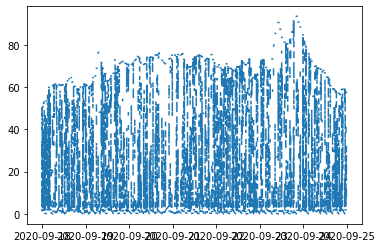

In [6]:
# Quick and dirty Depth timeseries plot
plt.plot(data.index, data.depth);

As we can see from this plot, and the snipped from the dataset above, there are a bunch of rows that are mostly NaNs.  We can easily clean up this dataset, using the following command.

In [7]:
# Drop rows with NaNs
data = data.dropna(subset=['depth'])
data.shape

(27161, 7)

## Glider Track Maps

If you don't care about [map projection](https://en.wikipedia.org/wiki/Map_projection), you can create a simple map using just the lat/lon.

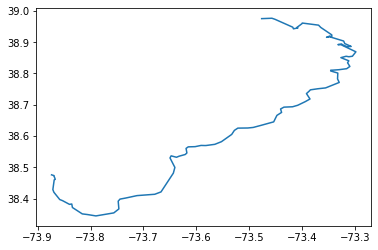

In [8]:
plt.plot(data['longitude'],data['latitude']);

But we can do better than that.  

In addition to plotting a variable in color (for this example, I'm coloring by time), we can also set the graph's *aspect ratio* so that the map looks more realistic, like a Mercator map.

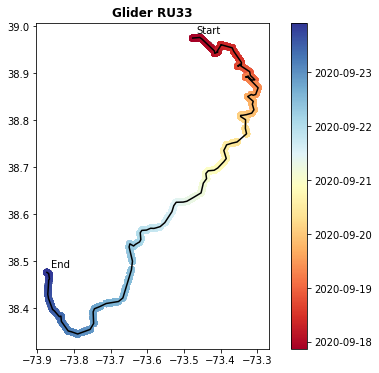

In [9]:
# Glider Deployment Map
plt.figure(figsize=(8,6))

plt.plot(data.longitude, data.latitude, c='black')
plt.scatter(data.longitude, data.latitude, c=data.index, cmap='RdYlBu')

# Label Start/End Points
plt.text(data.longitude.iloc[0]+.01, data.latitude.iloc[0]+.01, 'Start')
plt.text(data.longitude.iloc[-1]+.01, data.latitude.iloc[-1]+.01, 'End')

# Add a colorbar
cbar = plt.colorbar();

# Fix the colorbar ticks
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

# Set the aspect ratio to pseudo-Mercator
plt.gca().set_aspect(1 / np.cos(np.deg2rad( np.mean(plt.ylim()) )))

plt.title('Glider RU33', fontweight='bold');

There a lot more we can do to make the map prettier and more useful, like adding coastlines, gridlines and improving the tick labels.

Check out the appendix for more.

## Transect Plots
Perhaps the most common way to look at glider data is as a *transect*, where we basically plot the data as if it were a slice of the ocean that the glider flew through.

There are a few was to do this, but the easiest it with a colored scatterplot.

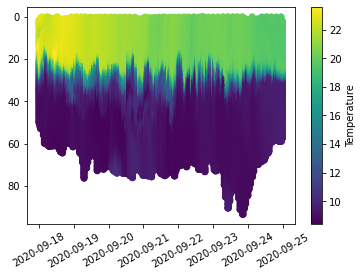

In [10]:
# Basic Transect plot
sc = plt.scatter(data.index, data['depth'], c=data['temperature']);

plt.gca().invert_yaxis(); # Flip the y-axis
plt.xticks(rotation=30); # Rotate the date labels

cb1 = plt.colorbar(sc,label='Temperature') # Add a colorbar

Of course, we can always do better.

The following example has a few features
* `plt.subplots()` allows us to create multiple plots
* We can specify the figure size using `figsize`
* vmin/vmax flags in the scatterplot line can be used to specify a narrower range for the colorbar limits.
* We've improved the date label display
* We can use `plt.savefig()` to save the file

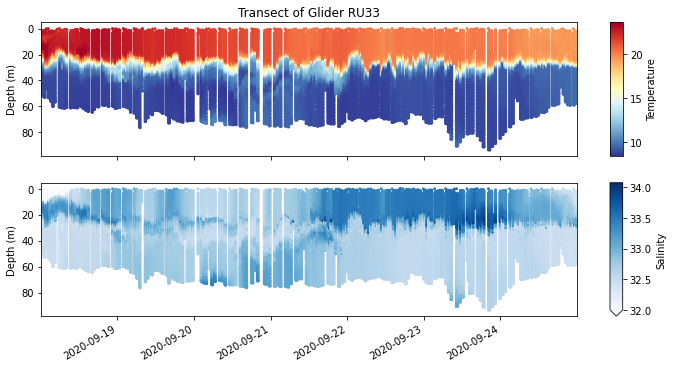

In [11]:
# Transect plots of Temperature and Salinity
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,6))
# fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,6), dpi=150) #Bigger plot

ms = 4 #Marker size - Adjust this based on the size of your plot

sc1 = ax1.scatter(data.index, data.depth, c=data.temperature, s=ms, cmap='RdYlBu_r')
sc2 = ax2.scatter(data.index, data.depth, c=data.salinity, s=ms, cmap='Blues', vmin=32) #vmax=34.2

cb1 = plt.colorbar(sc1, ax=ax1, aspect=10, label='Temperature')
cb2 = plt.colorbar(sc2,ax=ax2, aspect=10, label='Salinity', extend='min')

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(min(data.index),max(data.index)); # Set the time limits to match the dataset

# Fix the date ticks
# ax2.xaxis.set_tick_params(rotation=30); # Not the best
fig.autofmt_xdate() # Better

ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('Depth (m)')
ax1.set_title('Transect of Glider RU33')

plt.savefig("ru33_transect.png")

What if we want to just plot one day?  Well there are a few ways to do this.
1. We could always go back to the top, and change our data URL to just load the data we need.
2. We can change the date limits on the plot, just like we did above where we set it to the max/min.
3. We can subset our dataset after we load it, but before we plot it.

Let's try option #2, by specifying x-limits in the plot

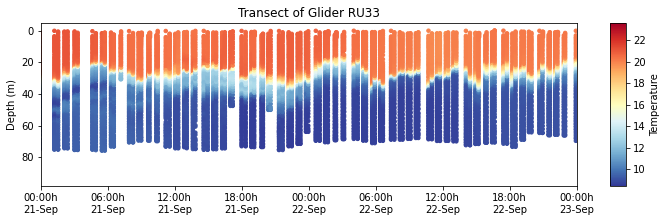

In [12]:
# Glider Transect plot
fig,ax1 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,3))
sc1 = ax1.scatter(data.index, data.depth, c=data.temperature, s=12, cmap='RdYlBu_r')
cb1 = plt.colorbar(sc1, ax=ax1, aspect=10, label='Temperature')
ax1.invert_yaxis() # Invert y axis

# Specify the date range we want to plot as year,month,day
import datetime
ax1.set_xlim( datetime.datetime(2020,9,21), datetime.datetime(2020,9,23) ); 

# Fancier Date Labels
import matplotlib.dates as mdates
xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
ax1.xaxis.set_major_formatter(xfmt)

ax1.set_ylabel('Depth (m)')
ax1.set_title('Transect of Glider RU33');

And now option #3, we will create a new dataset that subsamples the original one.

In [13]:
# Subset the Data
data2 = data['2020-09-21':'2020-09-22']

# Subset to the hour:minute
# data2 = data['2020-09-21 12:00':'2020-09-22 12:10']

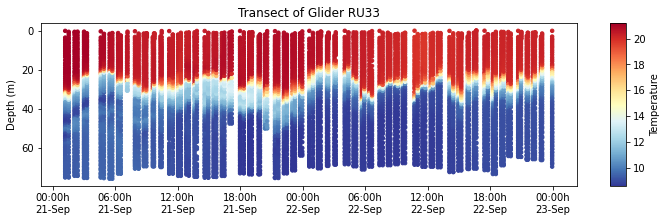

In [14]:
# 1-day Transect plot
fig,ax1 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,3))
sc1 = ax1.scatter(data2.index, data2.depth, c=data2.temperature, s=12, cmap='RdYlBu_r')
cb1 = plt.colorbar(sc1, ax=ax1, aspect=10, label='Temperature')
ax1.invert_yaxis() # Invert y axis

# Fancier Date Labels
xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
ax1.xaxis.set_major_formatter(xfmt)

ax1.set_ylabel('Depth (m)')
ax1.set_title('Transect of Glider RU33');

## Profiles and TS Diagrams (scatterplots)
At this point, we've basically covered all the basics.  Making profile plots, or colored scatter plots is really just a variation of what we've already done.

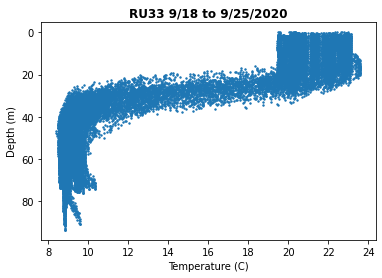

In [16]:
# Temperature Profile of all data
plt.scatter(data.temperature, data.depth, s=2)
plt.gca().invert_yaxis()
plt.xlabel('Temperature (C)')
plt.ylabel('Depth (m)');
plt.title('RU33 9/18 to 9/25/2020',fontweight='bold');

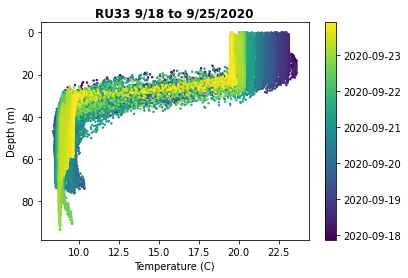

In [18]:
# Temperature Profile with Date
plt.scatter(data.temperature, data.depth, c=data.index, s=2)
plt.gca().invert_yaxis()

# Add a colorbar
cbar = plt.colorbar();
# Fix the colorbar ticks
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

plt.xlabel('Temperature (C)')
plt.ylabel('Depth (m)');
plt.title('RU33 9/18 to 9/25/2020',fontweight='bold');

Now let's plot profiles of temperature and salinity.

Notice the slight difference in how we call the label functions when we use plt.subplots().

For this example, we'll use the subsetted dataset we created above.

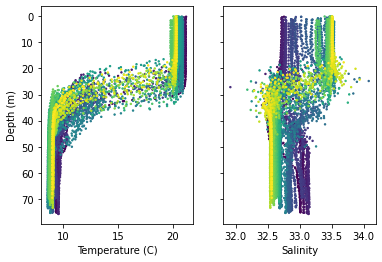

In [19]:
fig,(ax1,ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(data2.temperature, data2.depth, c=data2.index, s=2)
ax2.scatter(data2.salinity, data2.depth, c=data2.index, s=2)

ax1.invert_yaxis()

ax1.set_xlabel('Temperature (C)')
ax2.set_xlabel('Salinity')
ax1.set_ylabel('Depth (m)');
# plt.title('RU33 9/18 to 9/25/2020',fontweight='bold');

If we want to plot a single profile, we can do that too.

While we could subset the dataset to a single profile using a time range, this dataset includes a **profile_id** column that we can use, assuming we know which id we want.

In [20]:
# Subset a single profile
data_profile = data[data['profile_id']==1600358798]

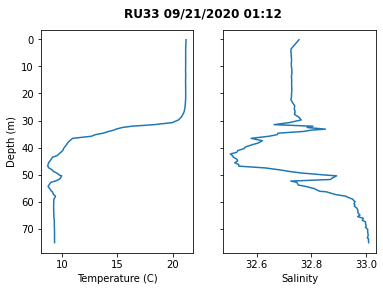

In [21]:
# Plot a single profile
fig,(ax1,ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(data_profile.temperature, data_profile.depth)
ax2.plot(data_profile.salinity, data_profile.depth)

ax1.invert_yaxis()

ax1.set_xlabel('Temperature (C)')
ax2.set_xlabel('Salinity')
ax1.set_ylabel('Depth (m)');

# A fancy way to include the date of the selected profile in the title
title = 'RU33 %s' % data_profile.index[0].strftime("%m/%d/%Y %H:%M")
fig.suptitle(title, fontweight='bold');
fig.subplots_adjust(top=0.9)

## Appendix 1 - Cmocean Colormaps
Choosing appropriate colors for your plots is not exactly trivial.  While a lot of plots in the past used a colormap consisting of a full rainbow (it's [not good](https://eos.org/features/visualizing-science-how-color-determines-what-we-see)), today scientists are more careful in their color choices.

The matplotlib library includes quite a few [colormaps](https://matplotlib.org/tutorials/colors/colormaps.html) you can use.

Another option is the [cmocean](https://matplotlib.org/cmocean/) library, which provides some colormaps especially designed for oceanography.  That said, I tend to prefer `RdYlBu_r` for temperature and `Blues_r` for salinity as used above.)

Here's how to install and use this library.

In [22]:
!pip install cmocean
import cmocean

     |████████████████████████████████| 225kB 6.0MB/s 


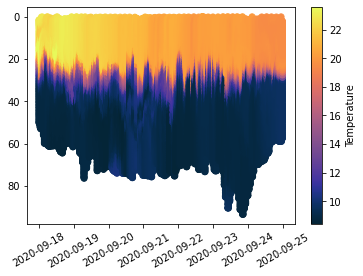

In [23]:
# Transect plot using cmocean colormap
sc = plt.scatter(data.index, data['depth'], c=data['temperature'], cmap=cmocean.cm.thermal);
plt.gca().invert_yaxis(); # Flip the y-axis
plt.xticks(rotation=30); # Rotate the date labels
cb1 = plt.colorbar(sc,label='Temperature') # Add a colorbar

## Appendix 2 - Some Statistics
One of the great features of the pandas library, is that you can easily use it to calculate some basic statistics.  

Here's an example using the single profile we extracted above.

In [24]:
data_profile.describe()

,profile_id,latitude,longitude,depth,temperature,salinity,density
count,9.800000e+01,9.800000e+01,9.800000e+01,98.000000,98.000000,98.000000,98.000000
mean,1.600359e+09,3.874763e+01,-7.338380e+01,42.675577,13.227274,32.786655,1024.702657
std,0.000000e+00,6.427763e-14,7.141959e-14,20.648169,5.255388,0.154566,1.259614
min,1.600359e+09,3.874763e+01,-7.338380e+01,0.146387,8.708300,32.503506,1022.736300
25%,1.600359e+09,3.874763e+01,-7.338380e+01,27.986249,9.254525,32.725131,1022.936650
50%,1.600359e+09,3.874763e+01,-7.338380e+01,44.557680,9.718150,32.743963,1025.394950
75%,1.600359e+09,3.874763e+01,-7.338380e+01,59.881000,20.878950,32.956445,1025.758675
max,1.600359e+09,3.874763e+01,-7.338380e+01,75.106890,21.206200,33.010742,1025.857300


If we want just one statistic for one column, we can extract it like this...

In [25]:
round( data_profile['temperature'].mean(), 2)

13.23

## Appendix 3 - Erddapy
To get the glider dataset we used above, we used the Erddap website to construct a valid URL.  If you are careful, once you have a URL you can tweak it carefully to change the date range or variables.

A better option might be the [erddapy library](https://ioos.github.io/erddapy/), which allows you to select and download datasets available on Erddap servers using much cleaner code.

Here is a quick example showing how we can use the library to specify a different date range for this particular glider deployment.

In [26]:
!pip install erddapy
from erddapy import ERDDAP

In [27]:
e = ERDDAP(
  server='https://gliders.ioos.us/erddap',
  protocol='tabledap',
)
e.response = 'csv'
e.dataset_id = 'ru33-20200826T1604'
e.constraints = {
    'time>=': '2020-10-01T00:00:00Z',
    'time<=': '2020-10-03T00:00:00Z',
    # 'latitude>=': 38.0,
    # 'latitude<=': 41.0,
    # 'longitude>=': -72.0,
    # 'longitude<=': -69.0,
}
e.variables = [
    'depth',
    'latitude',
    'longitude',
    'salinity',
    'temperature',
    'time',
]

df = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
).dropna()

In [28]:
df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (degrees_C)
time (UTC),,,,,
2020-10-01 00:00:27+00:00,2.829857,39.142807,-74.150116,31.705618,20.8865
2020-10-01 00:00:27+00:00,10.980398,39.142807,-74.150116,31.716105,20.8761
2020-10-01 00:00:27+00:00,11.931576,39.142807,-74.150116,31.717201,20.8739
2020-10-01 00:00:27+00:00,13.090846,39.142807,-74.150116,31.717201,20.8736
2020-10-01 00:00:27+00:00,14.041320,39.142807,-74.150116,31.717335,20.8731


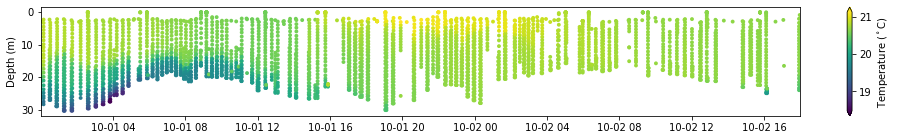

In [29]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df["depth (m)"], s=15, c=df["temperature (degrees_C)"], marker="o", edgecolor="none")

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])

cbar = fig.colorbar(cs, orientation="vertical", extend="both")
cbar.ax.set_ylabel("Temperature ($^\circ$C)")
ax.set_ylabel("Depth (m)");

You can also use the erddapy library to search for available datasets, without having to go to the web interface, but we won't get into that here.

## Appendix 4 - Better Maps

The maps we created above were still pretty crude.  For better maps in Python, we can use the [cartopy library](https://scitools.org.uk/cartopy/docs/latest/).

The cartopy library provides a lot of great features to create your own custom maps, but it takes a bit of patience to get it to work correctly (especially in Colab).

In [30]:
!apt-get -qq install python-cartopy python3-cartopy

Selecting previously unselected package python-pkg-resources.
(Reading database ... 144618 files and directories currently installed.)
Preparing to unpack .../0-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../1-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../2-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../4-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../5-pyth

In [31]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

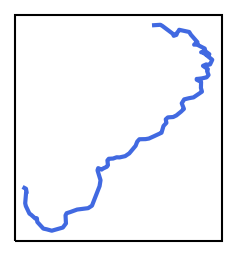

In [32]:
# Quick Glider Map
fig = plt.figure(figsize=(2,2),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.plot(data.longitude, data.latitude, linewidth=2, color='royalblue');

That's a nice map with a better projection.

But to make a fancier map in Cartopy (with coastlines and gridlines), we need to override the outdated version that Google Colab has and reinstall cartopy using this [hack](https://github.com/googlecolab/colabtools/issues/833).  (Hopefully this will eventually become moot.)  You may also need to "Factory Reset" your runtime first for this to work.

In [1]:
# Hack to update cartopy
!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get update

!apt-get -qq build-dep python3-cartopy
!apt-get -qq remove python-shapely python3-shapely

!pip install --no-binary shapely shapely --force
!pip install --no-binary cartopy cartopy==0.18.0 #Updated

deb-src http://archive.ubuntu.com/ubuntu/ bionic main restricted
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates main restricted
deb-src http://archive.ubuntu.com/ubuntu/ bionic universe
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates universe
deb-src http://archive.ubuntu.com/ubuntu/ bionic multiverse
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates multiverse
deb-src http://archive.ubuntu.com/ubuntu/ bionic-backports main restricted universe multiverse
deb-src http://security.ubuntu.com/ubuntu/ bionic-security main restricted
deb-src http://security.ubuntu.com/ubuntu/ bionic-security universe
deb-src http://security.ubuntu.com/ubuntu/ bionic-security multiverse
deb-src https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/mach

In [2]:
# Reload dataset
import pandas as pd
url = 'https://gliders.ioos.us/erddap/tabledap/ru33-20200826T1604.csv?profile_id%2Ctime%2Clatitude%2Clongitude%2Cdepth%2Ctemperature%2Csalinity%2Cdensity&time%3E=2020-09-18T00%3A00%3A00Z&time%3C=2020-09-25T00%3A00%3A00Z'
data = pd.read_csv(url, skiprows=[1], parse_dates=['time'], index_col='time')

In [3]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

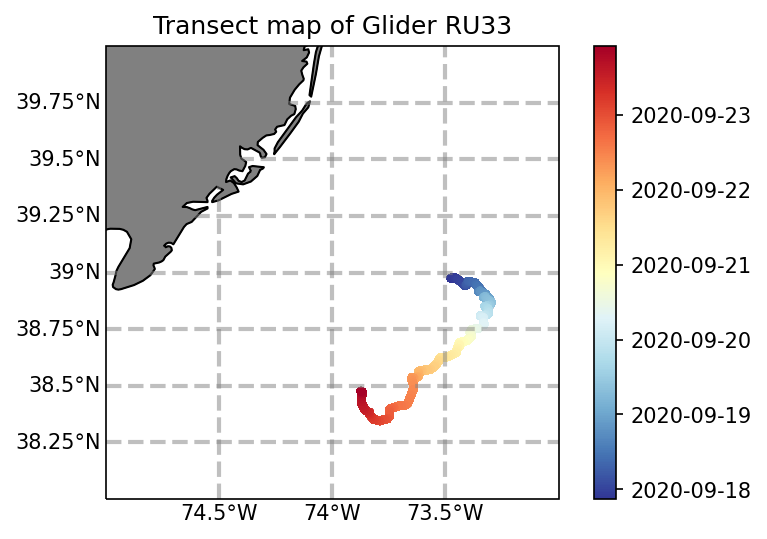

In [5]:
fig = plt.figure(figsize=(6,4),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-75, -73, 38, 40], crs=ccrs.PlateCarree())

# Basemaps
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black",facecolor='grey')
ax.coastlines('10m', linewidth=1)

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.MaxNLocator(4)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Glider Data
plt.scatter(data.longitude, data.latitude, c=data.index, marker='.', cmap='RdYlBu_r', transform=ccrs.PlateCarree());

# Colorbar
cbar = plt.colorbar()
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d')); #Fix the colorbar ticks

plt.title('Transect map of Glider RU33');
plt.savefig("ru33_map.png");

## Additional References
* [Working with NetCDF files in Matlab](https://oceanobservatories.org/knowledgebase/working-with-netcdf-files-in-matlab/)
* [Plotting Glider Transects in Matlab](https://oceanobservatories.org/knowledgebase/plotting-glider-transects-in-matlab/)
* [Making a Glider Deployment Map in Matlab](https://oceanobservatories.org/knowledgebase/making-a-glider-deployment-map-in-matlab/)
* [Anoxia Activity](https://github.com/ooi-data-lab/data-lab-workshops/blob/master/March2019/Activities/DL_March_Anoxia_v4.ipynb) - Includes example glider plot from which much of this tutorial was based